# Amino Acids


Many of the possible uptakes for MED4 are amino acid.

The goal of this notebook is to answer the questions
- Why are only a subset of amino acids in the list?
   1. run pFBA and search for the reactions that enable production of all amino acids from the amino acids on the uptake list, do they simply produce ammonium?
   2. use gap filling to identify missing reactions that may enable growth on the amino acids that are not sufficient for growth
GEMdiff


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [3]:
from bokeh.models import Range1d, Plot
from bokeh.plotting import from_networkx


In [4]:
import subprocess
import time


In [5]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [6]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [9]:
import networkx as nx

In [10]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   ["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   ["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [11]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'mid' : m.id,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

In [12]:
pro_df = pd.read_excel('data/PRO_N_sources.xlsx', sheet_name='uptake')

# Import model and manipulate based on Ofaim at el

In [13]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7_with_formula.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [14]:
model = cobra.io.read_sbml_model(model_fpath)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [15]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [16]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [17]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [18]:
model

Name,COBRAModel
Memory address,0x07f913116cd60
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [19]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7f91310ada00
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R07316, R03546, R01395, R10949"


In [20]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


# Get list of Amino Acids

In [21]:
aa = model.metabolites.get_by_id('amino_acid_pool[c]')

In [22]:
BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
amino_acid_metabolites

[<Metabolite L_Glutamate[c] at 0x7f9131174520>,
 <Metabolite Glycine[c] at 0x7f91311746d0>,
 <Metabolite L_Alanine[c] at 0x7f9131174730>,
 <Metabolite L_Lysine[c] at 0x7f91311747f0>,
 <Metabolite L_Aspartate[c] at 0x7f9131174850>,
 <Metabolite L_Arginine[c] at 0x7f9131174a00>,
 <Metabolite L_Glutamine[c] at 0x7f9131174a60>,
 <Metabolite L_Serine[c] at 0x7f9131174a90>,
 <Metabolite L_Methionine[c] at 0x7f9131174b50>,
 <Metabolite L_Tryptophan[c] at 0x7f9131174c40>,
 <Metabolite L_Phenylalanine[c] at 0x7f9131174c70>,
 <Metabolite L_Tyrosine[c] at 0x7f9131174cd0>,
 <Metabolite L_Leucine[c] at 0x7f913108d280>,
 <Metabolite L_Histidine[c] at 0x7f913108d370>,
 <Metabolite L_Proline[c] at 0x7f913108d520>,
 <Metabolite L_Asparagine[c] at 0x7f913108d5b0>,
 <Metabolite L_Valine[c] at 0x7f913108d7f0>,
 <Metabolite L_Threonine[c] at 0x7f913108d850>,
 <Metabolite L_Isoleucine[c] at 0x7f913109d460>,
 <Metabolite L_Cystine[c] at 0x7f913109d820>]

In [23]:
model.reactions.BFreeaminoacids.summary()

In [24]:
amino_acid_metabolites[15].summary()

Percent,Flux,Reaction,Definition
100.00%,0.005907,R00485,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c]
Percent,Flux,Reaction,Definition
7.01%,-0.000414,BFreeaminoacids,0.25719 Glycine[c] + 1.0449 L_Alanine[c] + 0.20897 L_Arginine[c] + 0.27327 L_Asparagine[c] + 0.46616 L_Aspartate[c] + 0.04019 L_Cystine[c] + 2.0415 L_Glutamate[c] + 1.3342 L_Glutamine[c] + 0.22504 L_Histidine[c] + 0.10448 L_Isoleucine[c] + 0.1286 L_Leucine[c] + 0.17682 L_Lysine[c] + 0.04019 L_Methionine[c] + 0.04019 L_Phenylalanine[c] + 0.41392 L_Proline[c] + 0.37775 L_Serine[c] + 0.24916 L_Threonine[c] + 0.01607 L_Tryptophan[c] + 0.04822 L_Tyrosine[c] + 0.1286 L_Valine[c] --> amino_acid_pool[c]
92.99%,-0.005493,BProtein,34.99 ATP[c] + 0.57844 Glycine[c] + 0.54397 L_Alanine[c] + 0.51716 L_Arginine[c] + 0.13121 L_Asparagine[c] + 0.39361 L_Aspartate[c] + 0.13791 L_Cystine[c] + 0.67517 L_Glutamate[c] + 0.22506 L_Glutamine[c] + 0.19153 L_Histidine[c] + 0.32178 L_Isoleucine[c] + 0.6474 L_Leucine[c] + 0.57844 L_Lysine[c] + 0.41373 L_Methionine[c] + 0.25666 L_Phenylalanine[c] + 0.39456 L_Proline[c] + 0.0011644 L_Selenocysteine[c] + 0.11644 L_Selenomethionine[c] + 0.39456 L_Serine[c] + 0.40989 L_Threonine[c] + 0.053629 L_Tryptophan[c] + 0.18005 L_Tyrosine[c] + 0.53631 L_Valine[c] --> 34.99 ADP[c] + 34.99 Orthophosphate[c] + Protein[c]


# What are the reactions used to generate each of the amino acids?

In [25]:
pro_df.head()

,Unnamed: 0,uptake,objective_value,reaction,metabolite,mid,N,C
0,0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],Guanosine[e],True,True
1,1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,L_Aspartate[e],True,True
2,2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],Glutathione[e],True,True
3,3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,L_Glutamine[e],True,True
4,4,L_SerineEX,0.118972,L_SerineEX,L-Serine,L_Serine[e],True,True


In [26]:
# get the internal metabolite and internal transfer reaction from the exchange reaction
# needed because the exchange reaction does not contain the internal metabolite
def get_trans_reaction_and_internal_metabolite(met1):
    r_met1 = model.reactions.get_by_id(met1)
    m_met1_list = list(r_met1.metabolites.keys())
    assert(len(m_met1_list) ==1)
    m_external_met1 = m_met1_list[0]
    r_trans_list = [r for r in m_external_met1.reactions if r is not r_met1]
    assert(len(r_trans_list) ==1)
    r_trans = r_trans_list[0]
    m_internal_met1_list = [m for m in r_trans_list[0].metabolites.keys() if m is not m_external_met1]
    if (len(m_internal_met1_list) >1):
        # cyanate ABC transporter has more than 1
        m_internal_met1_list = [m for m in m_internal_met1_list if m.name == m_external_met1.name]
    assert(len(m_internal_met1_list) ==1)
    m_internal_met1 = m_internal_met1_list[0]
    return (r_trans, m_internal_met1)

In [27]:
def get_products(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.reactants
    else:
        return r.products
    

In [28]:
def get_pfba_flux(r, pfba_solution):
    f = pfba_solution.get_primal_by_id(r.id)
    if r.reversibility and (f < 0):
        return -f
    else:
        return f
    

In [29]:
def get_consuming_reactions(m, pfba_solution):
    reaction_list =  [
        r 
        for r in m.reactions 
        if ((m not in get_products(r, pfba_solution)) and
            (get_pfba_flux(r, pfba_solution) > 0))
    ]

    flux_list = [get_pfba_flux(r, pfba_solution)  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [30]:
def get_producing_reactions(m, pfba_solution):
    reaction_list =  [
        r for r in m.reactions 
        if (r not in get_consuming_reactions(m, pfba_solution)) and 
        (get_pfba_flux(r, pfba_solution) != 0)
    ]

    flux_list = [np.abs(get_pfba_flux(r, pfba_solution))  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [31]:
def get_percent_produced(met1, reaction1, pfba_solution):
    """ 
    what is the percent of flux of r out of the total reactions producing m
    how significant is r in m production
    """
    percent_list = [p for (r,f,p) in get_producing_reactions(met1, pfba_solution) if r == reaction1]
    if len(percent_list) == 1:
        #print(f'!!!!reaction {reaction1.id} FOUND in metabolite {met1}')
        return percent_list[0]
    
    if len(percent_list) == 0:
        if get_pfba_flux(reaction1, pfba_solution) != 0:
            print(f'reaction {reaction1.id} not found in metabolite {met1}')
        return 0
    assert((len(percent_list)<2), f'reaction {reaction1.id} found more than once in metabolite {met1}')
    

<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_2367182/2231482876.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((len(percent_list)<2), f'reaction {reaction1.id} found more than once in metabolite {met1}')


In [32]:
from enum import Enum, auto
class DFS_STATUS(Enum):
     VISITED = auto()
     FOUND = auto()
     NOT_FOUND = auto()

In [33]:
def get_path(cur_reaction, amino_acid_metabolites, ammonium_metabolite, visited, pfba_solution):
    found_paths = list()
    final_status = DFS_STATUS.NOT_FOUND
    if cur_reaction in visited:
        return (DFS_STATUS.VISITED, [])
    visited.add(cur_reaction)
    m_products = get_products(cur_reaction, pfba_solution)
    if (cur_reaction.id == 'CyanateTRANS'):
        # ugly workaorund for cyanate
        m_products = [m for m in m_products if m.id == 'Cyanate[c]']
    if ammonium_metabolite in m_products:
        percent_production = get_percent_produced(ammonium_metabolite, cur_reaction, pfba_solution)
        if percent_production > 1e-2:
            return (DFS_STATUS.FOUND, [[(ammonium_metabolite, cur_reaction, percent_production)]])
    found_amino_acids = list(set(amino_acid_metabolites) & set(m_products))
    if len(found_amino_acids)>0:
        found_paths = [[(aa, cur_reaction, get_percent_produced(aa, cur_reaction, pfba_solution))] for aa in found_amino_acids]
        found_paths = [[(aa,r,p)] for [(aa,r,p)] in found_paths if p > 1e-2]
        if found_paths:
            final_status = DFS_STATUS.FOUND
        #return (DFS_STATUS.FOUND, found_paths)
    for m in m_products:
        if m in visited:
            continue
        visited.add(m)
        metabolites_to_skip= ['H2O[c]','H[c]','ADP[c]','ATP[c]', 'NADP[c]', 'NADPH[c]']
        metabolites_to_skip= ['H2O[c]','H[c]']
        #metabolites_to_skip= []
        if m.id in metabolites_to_skip:
            continue
        if m in amino_acid_metabolites:
            continue
        if not 'N' in m.elements:
            continue
        percent_production = get_percent_produced(m, cur_reaction, pfba_solution)
        if percent_production < 1e-2:
            # less than one percent - not interesting
            continue
        r_consuming_reactions = get_consuming_reactions(m, pfba_solution)
        for (r, flux, percent) in r_consuming_reactions:
            if (r.id == 'BIOMASS') or (r.id == 'BFreeaminoacids') or (r.id == 'BProtein'):
                continue
            _status, _path = get_path(r, amino_acid_metabolites, ammonium_metabolite, visited, pfba_solution)
            if _status is DFS_STATUS.FOUND:
                path_list = [p + [(m ,cur_reaction, percent_production)] for p in _path]
                found_paths += path_list
                final_status = DFS_STATUS.FOUND
    return (final_status, found_paths)
    

In [34]:
def pathlist_to_dataframe(paths, pfba_solution, met1):
    df_paths = pd.DataFrame.from_records([
        {
            'path_id' : i,
            'Index' : j,
            'Uptake' : met1,
            'Product' : m.name,
            'Reaction'   : r.id,
            'Name' : r.name,
            'Flux'          : get_pfba_flux(r, pfba_solution),
            'Definition'    : r.reaction,
            'Percent_Production' : percent,
            'Group' :  ','.join([g.name for g in model.groups if r in g.members]),
            'Group_Annotation' :  ','.join([g.annotation['sbo'] for g in model.groups if r in g.members]),
        }
        for i,p in enumerate(paths, start=1)
        for j,(m,r,percent) in enumerate(reversed(p), start=1)
    ])   
    return df_paths


In [35]:
 get_trans_reaction_and_internal_metabolite('CyanateEX')


(<Reaction CyanateTRANS at 0x7f9130c67be0>,
 <Metabolite Cyanate[c] at 0x7f91310ad940>)

In [36]:
def get_paths_to_aa(model, met1):
    print (met1)
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        pfba_solution = cobra.flux_analysis.pfba(model)
        fva_fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)

        
        ammonia_trans, ammonia_metabolite = get_trans_reaction_and_internal_metabolite('AmmoniaEX')        
        BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
        amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
        amino_acid_metabolites
        
        met1_trans, met1_metabolite = get_trans_reaction_and_internal_metabolite(met1)        
        visited = set()
        _status, met1_paths = get_path(
            met1_trans, 
            set(amino_acid_metabolites) - set([met1_metabolite]), 
            ammonia_metabolite, 
            visited, 
            pfba_solution)    
        return (pathlist_to_dataframe(met1_paths, pfba_solution, met1), pfba_solution, fva_fluxes)
        

In [37]:
res_list = [get_paths_to_aa(model, uptake) for uptake in pro_df.uptake]
df_paths_list,pfba_solution_list, fva_fluxes_list = list(zip(*res_list))    

GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
L_CystineEX
L_AlanineEX
L_LeucineEX
GlycineEX
UreaEX
AmmoniaEX
L_GlutamateEX
L_ArginineEX
CyanateEX
L_ValineEX
GuanineEX


In [38]:
def _pfba_to_df (uptake, solultion):
    df = solultion.to_frame()
    df['Uptake'] = uptake
    return df
pfba_df = pd.concat([_pfba_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, pfba_solution_list)])


In [39]:
def _fva_to_df (uptake, df):
    df['Uptake'] = uptake
    return df
fva_df = pd.concat([_fva_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, fva_fluxes_list)])


In [40]:
fva_df = fva_df.reset_index().rename(columns={'index': 'Reaction'})

In [41]:
pfba_df = pfba_df.reset_index().rename(columns={'index': 'Reaction'})

In [42]:
flux_df = pd.merge(fva_df, pfba_df, on=['Uptake', 'Reaction'])

In [43]:
pfba_df.loc[np.isclose(pfba_df.fluxes, 0, atol=1e-5), 'fpba_status'] ='inactive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes > 1e-5), 'fpba_status'] ='positive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes < -1e-5), 'fpba_status'] ='negative'


In [44]:
pfba_df.head()

,Reaction,fluxes,reduced_costs,Uptake,fpba_status
0,R01055,0.000000,2.00000,GuanosineEX,inactive
1,R00546,0.000000,2.00000,GuanosineEX,inactive
2,R05605,7.889429,-2.00000,GuanosineEX,positive
3,R00346,0.000000,18.10219,GuanosineEX,inactive
4,R00355,0.532450,-2.00000,GuanosineEX,positive


In [45]:
def _get_group(rid):
    r = model.reactions.get_by_id(rid)
    return ','.join([g.name for g in model.groups if r in g.members])
pfba_df['Group'] = pfba_df.Reaction.map(_get_group)

In [46]:
import colorcet as cc

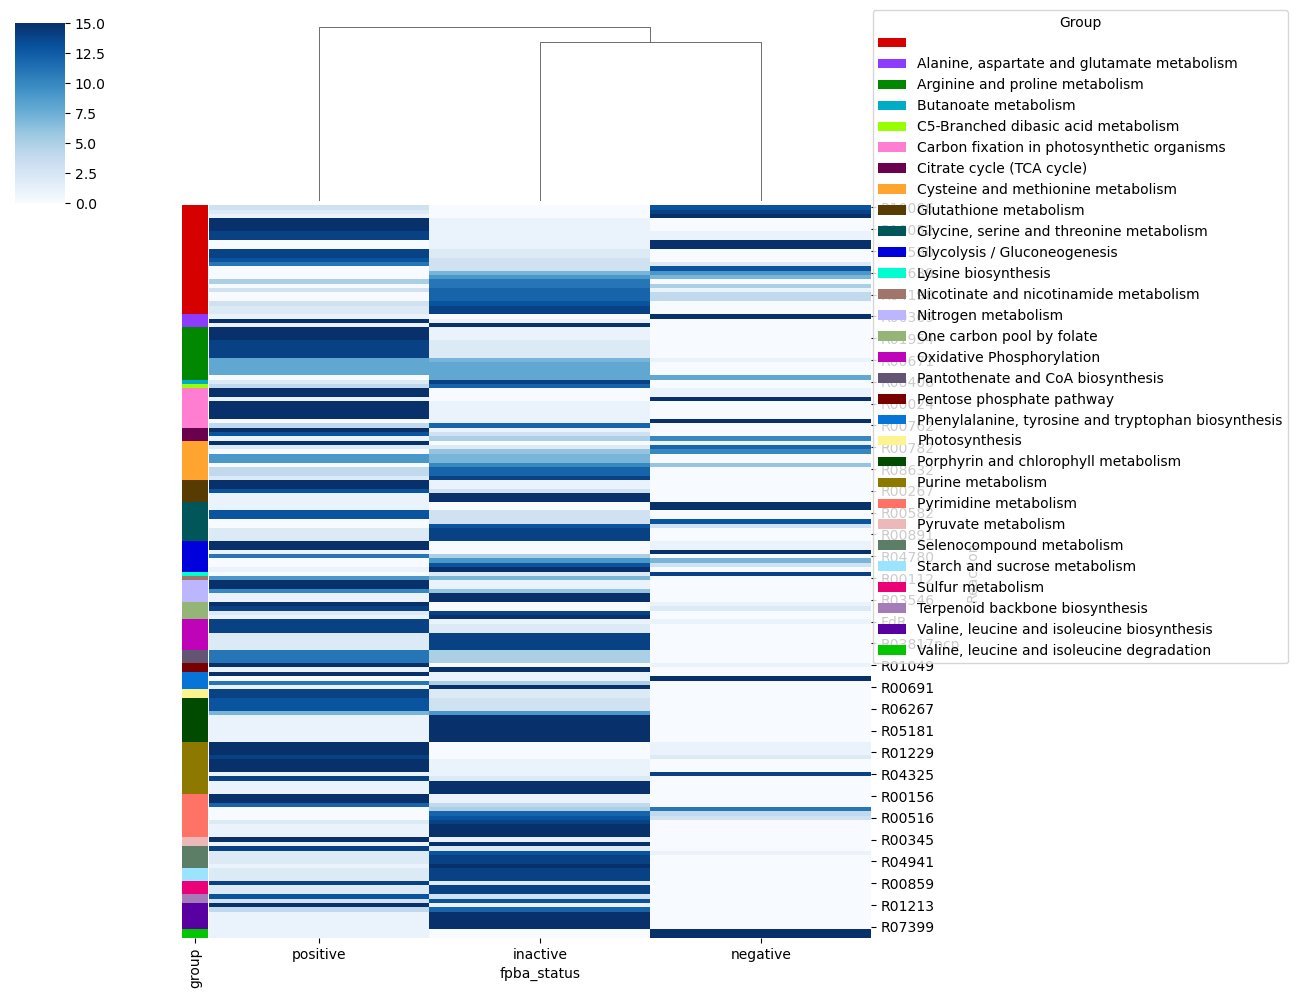

In [47]:
from matplotlib.patches import Patch

pdf = pfba_df.pivot_table(index='Reaction', columns='fpba_status', values='Uptake', aggfunc='nunique', fill_value=0)
pdf = pdf.loc[
    (pdf.inactive != 16) &
    (pdf.positive != 16) &
    (pdf.negative != 16) &
    ~pdf.index.to_series().str.contains('trans', case=False) & 
    ~pdf.index.to_series().isin(exchange_ids)     
]

cols = ['inactive', 'negative', 'positive',]
#cols = ['negative', 'positive',]
pdf['group'] = pdf.index.to_series().map(_get_group)
pdf = pdf.sort_values(['group'] + cols)
glist = pdf['group']

# glist = pdf.index.to_series().map(_get_group)
# glist = glist.sort_values()
# pdf = pdf.reindex(index=glist.index)

lut = dict(zip(glist.unique(), sns.color_palette(cc.glasbey, glist.nunique())))
sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut), row_cluster=False)
#sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut))
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Group',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [48]:
pdf.shape

(168, 4)

In [49]:
len(df_paths_list)

16

In [50]:
df_paths = pd.concat(df_paths_list)


In [51]:
df_paths['Reactant'] = df_paths.Product.shift()
df_paths.loc[df_paths.Index.isin([1]), 'Reactant'] = df_paths.loc[df_paths.Index.isin([1]), 'Product']

In [52]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(10,)

In [53]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [54]:
df_paths.groupby(['Uptake'])['path_id'].nunique()

Uptake
AmmoniaEX         1
CyanateEX         2
GlutathioneEX    10
GlycineEX         3
GuanineEX         1
GuanosineEX       1
L_AlanineEX       1
L_ArginineEX      1
L_AspartateEX    16
L_CystineEX       7
L_GlutamateEX    20
L_GlutamineEX     4
L_LeucineEX       1
L_SerineEX       12
L_ValineEX        1
UreaEX            1
Name: path_id, dtype: int64

In [55]:
df_paths.columns


Index(['path_id', 'Index', 'Uptake', 'Product', 'Reaction', 'Name', 'Flux',
       'Definition', 'Percent_Production', 'Group', 'Group_Annotation',
       'Reactant', 'group_color'],
      dtype='object')

In [56]:
df_paths.groupby(
    ['Reactant', 'Product', 'Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reactant,Product,Reaction,Name,Definition,0
15,ADP,ATP,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],25
16,AMP,ADP,R00127,ATP:AMP phosphotransferase,AMP[c] + ATP[c] <=> 2.0 ADP[c],25
78,L-Glutamate,L-Glutamate,GlutamateTRANS,L_Glutamate Transport,L_Glutamate[c] <=> L_Glutamate[e],20
61,L-Aspartate,L-Aspartate,AspartateTRANS,L_Aspartate Transport,L_Aspartate[c] <=> L_Aspartate[e],16
33,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],15
119,Malonyl-CoA,CoA,R01626,Malonyl-CoA:[acyl-carrier-protein] S-malonyltransferase,Acyl_carrier_protein[c] + Malonyl[c] --> CoA[c] + Malonyl_acyl_carrier_protein[c],14
131,NADH,NAD+,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],14
134,NADPH,L-Aspartate 4-semialdehyde,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],14
23,ATP,Malonyl-CoA,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],13
57,L-Aspartate,AMP,R00485,L-Asparagine amidohydrolase,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c],13


In [57]:
df_paths.groupby(
    ['Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reaction,Name,Definition,0
14,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],25
16,R00127,ATP:AMP phosphotransferase,AMP[c] + ATP[c] <=> 2.0 ADP[c],25
7,GlutamateTRANS,L_Glutamate Transport,L_Glutamate[c] <=> L_Glutamate[e],20
20,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],19
3,AspartateTRANS,L_Aspartate Transport,L_Aspartate[c] <=> L_Aspartate[e],16
79,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],16
30,R00485,L-Asparagine amidohydrolase,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c],15
40,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],14
44,R00945,"5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase",5_10_Methylenetetrahydrofolate[c] + Glycine[c] + H2O[c] <=> L_Serine[c] + Tetrahydrofolate[c],14
66,R01626,Malonyl-CoA:[acyl-carrier-protein] S-malonyltransferase,Acyl_carrier_protein[c] + Malonyl[c] --> CoA[c] + Malonyl_acyl_carrier_protein[c],14


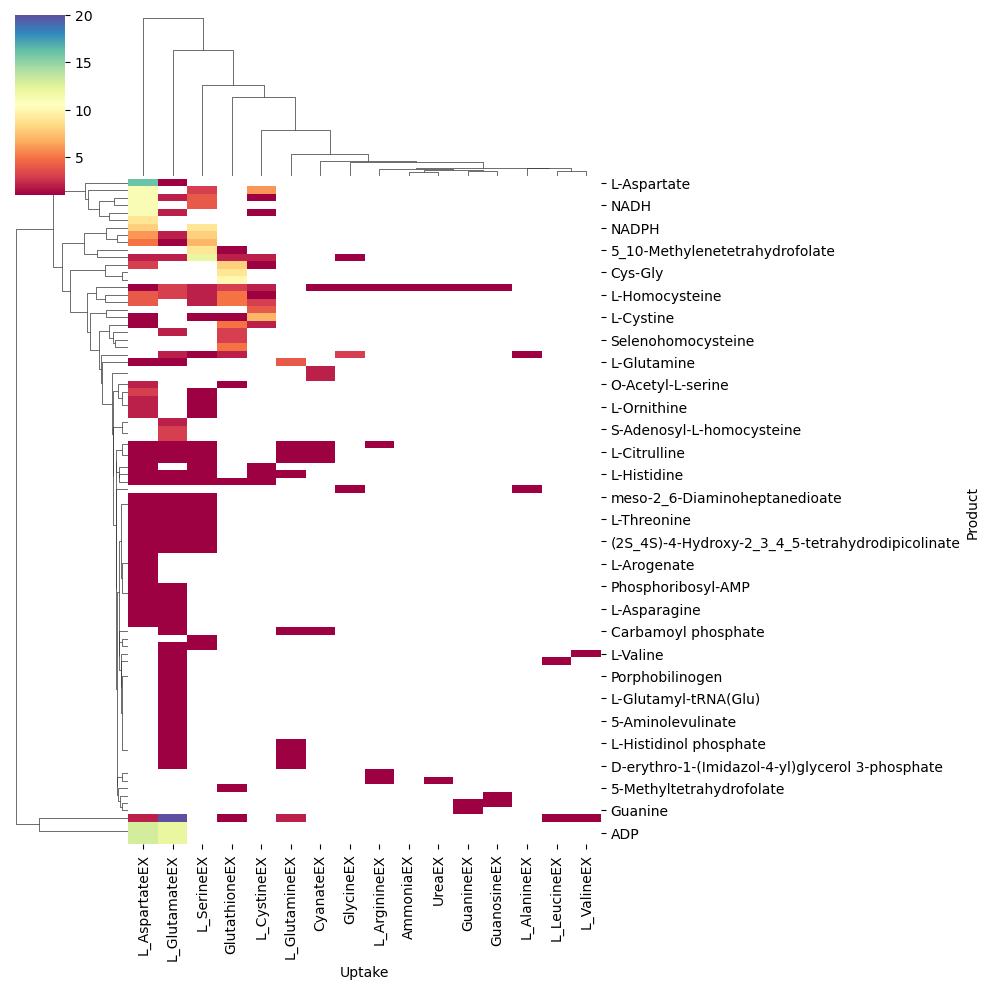

In [58]:
pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Reaction', aggfunc='count', fill_value=0)

sns.clustermap(pdf, mask=(pdf==0), cmap='Spectral')


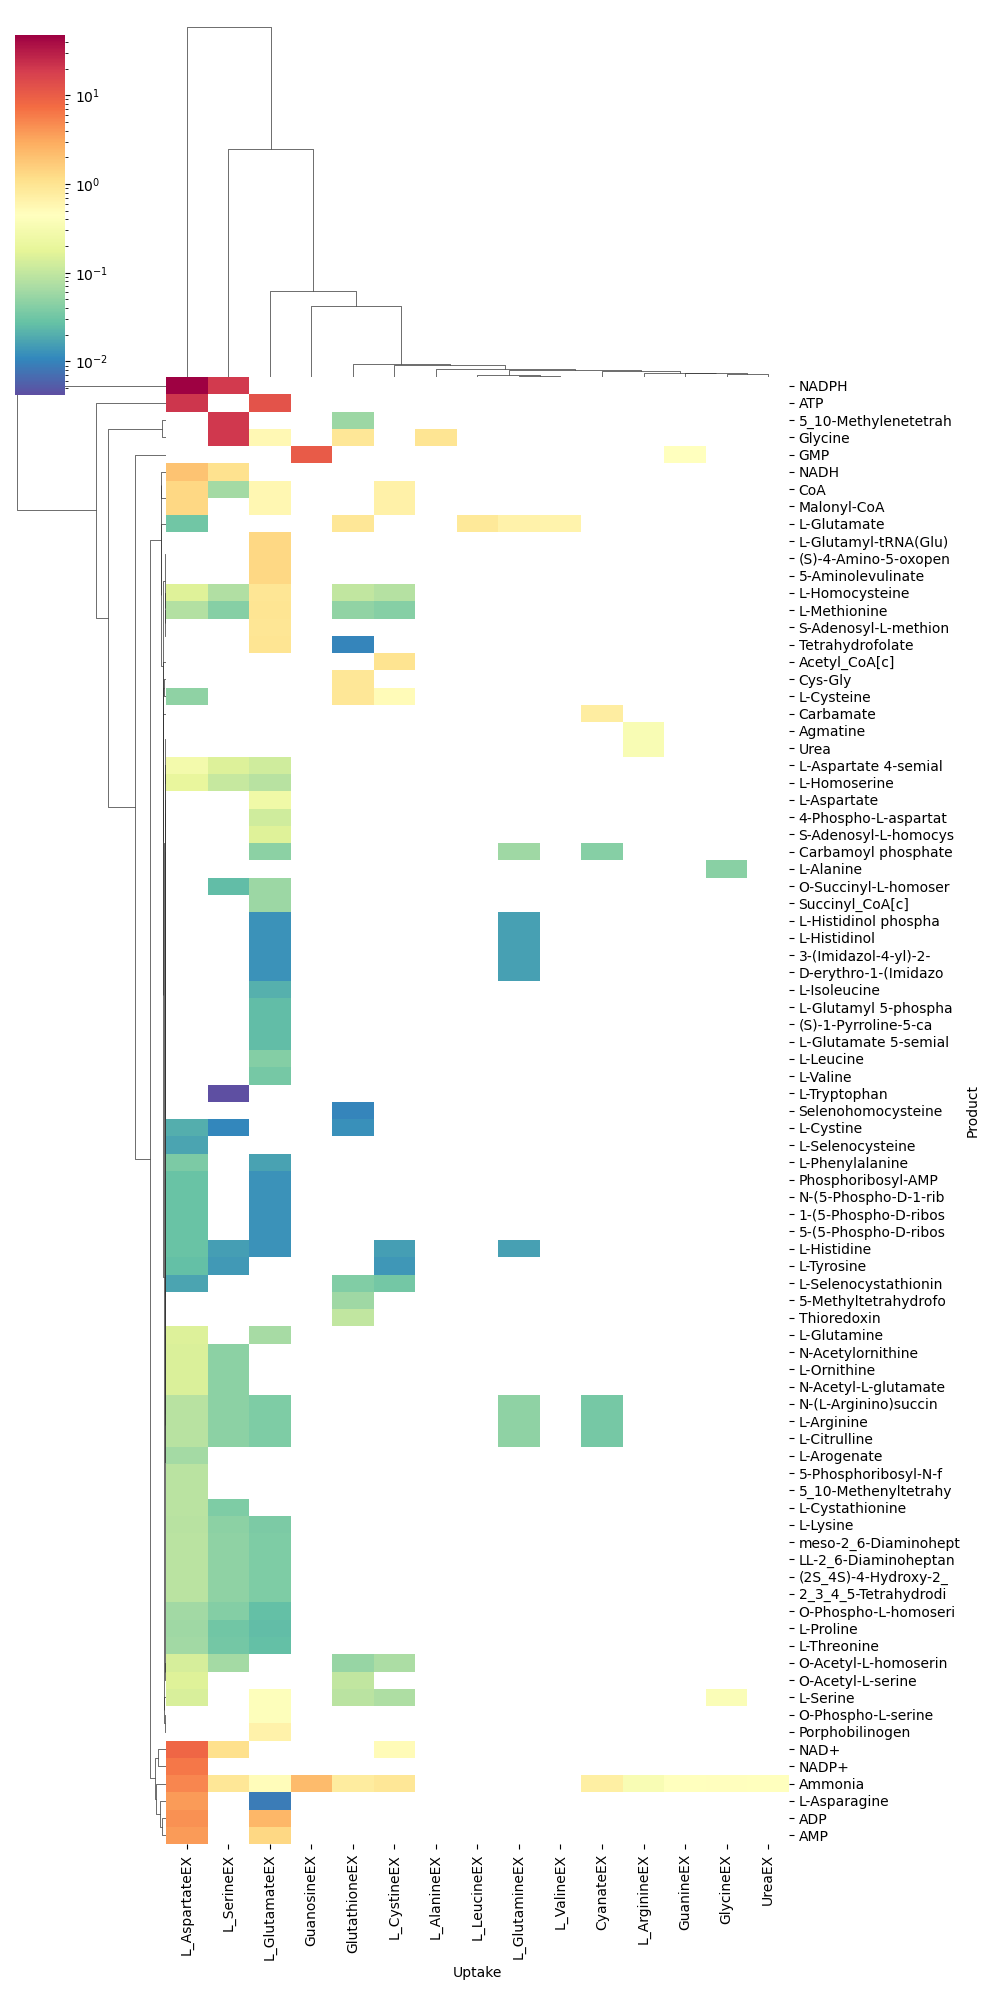

In [59]:

pdf = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].pivot_table(columns='Uptake', index='Product', values='Flux', aggfunc='max', fill_value=0)
sel = (pdf == 0).sum(axis=1) > 2

sns.clustermap(
    pdf.loc[sel], mask=(pdf.loc[sel]==0), cmap='Spectral_r', norm=LogNorm(),
    yticklabels= pdf.loc[sel].index.str.slice(0, 20),
    figsize=(10,20),

              )

In [60]:
pdf

Uptake,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Product,,,,,,,,,,,,,,,
(2S_4S)-4-Hydroxy-2_3_4_5-tetrahydrodipicolinate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.088287,0.0,0.038740,0.0,0.0,0.047388,0.0,0.0
(S)-1-Pyrroline-5-carboxylate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.025861,0.0,0.0,0.000000,0.0,0.0
(S)-4-Amino-5-oxopentanoate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.288349,0.0,0.0,0.000000,0.0,0.0
1-(5-Phospho-D-ribosyl)-ATP,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.028735,0.0,0.012609,0.0,0.0,0.000000,0.0,0.0
2_3_4_5-Tetrahydrodipicolinate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.088287,0.0,0.038740,0.0,0.0,0.047388,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Succinyl_CoA[c],0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.057776,0.0,0.0,0.000000,0.0,0.0
Tetrahydrofolate,0.0,0.010375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.982810,0.0,0.0,0.000000,0.0,0.0
Thioredoxin,0.0,0.097777,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [61]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=1000, columns='Flux').Reaction.unique()

In [62]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=300, columns='Flux').Reaction.unique()

In [63]:
(df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].groupby('Product').Uptake.nunique() > 1).sum()

54

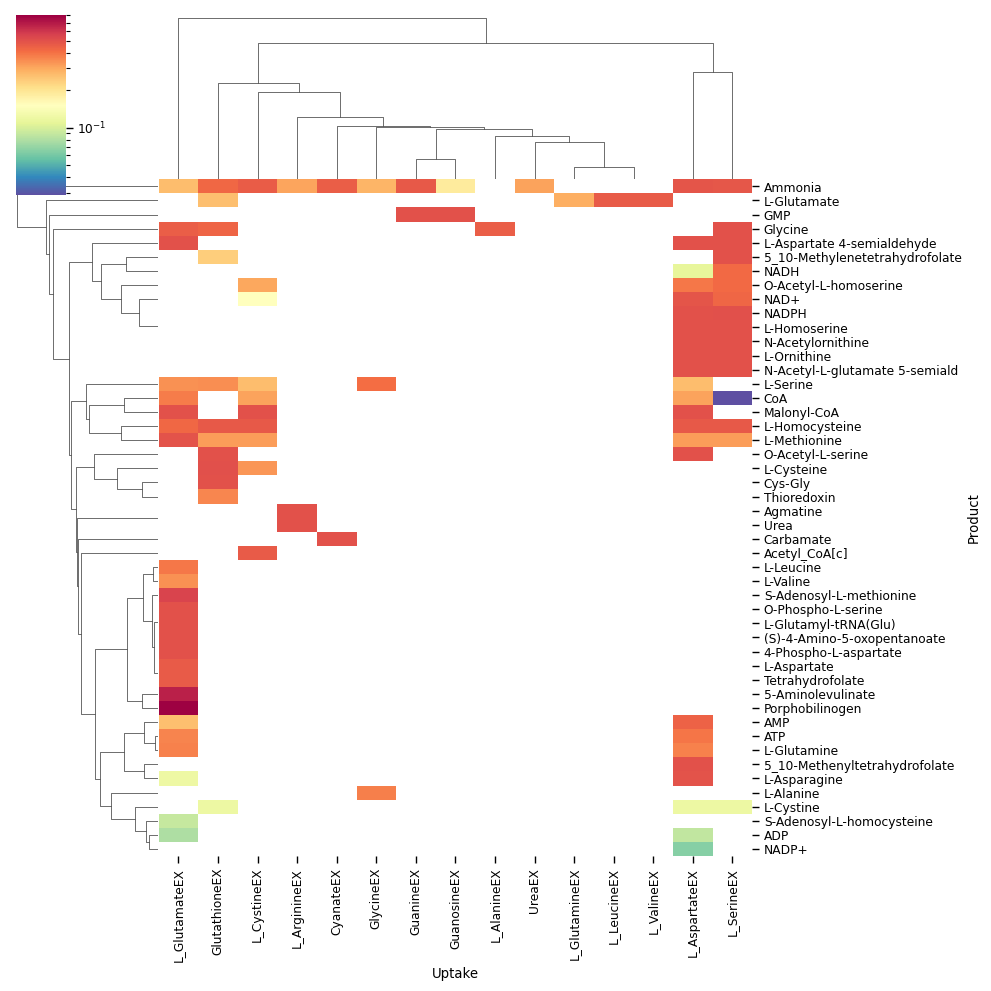

In [64]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)].pivot_table(columns='Uptake', index=['Product',#'Name'
                                                                                              ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', norm=LogNorm(),
    figsize=(10,10),
    yticklabels= pdf.index.str.slice(0, 30),

              )

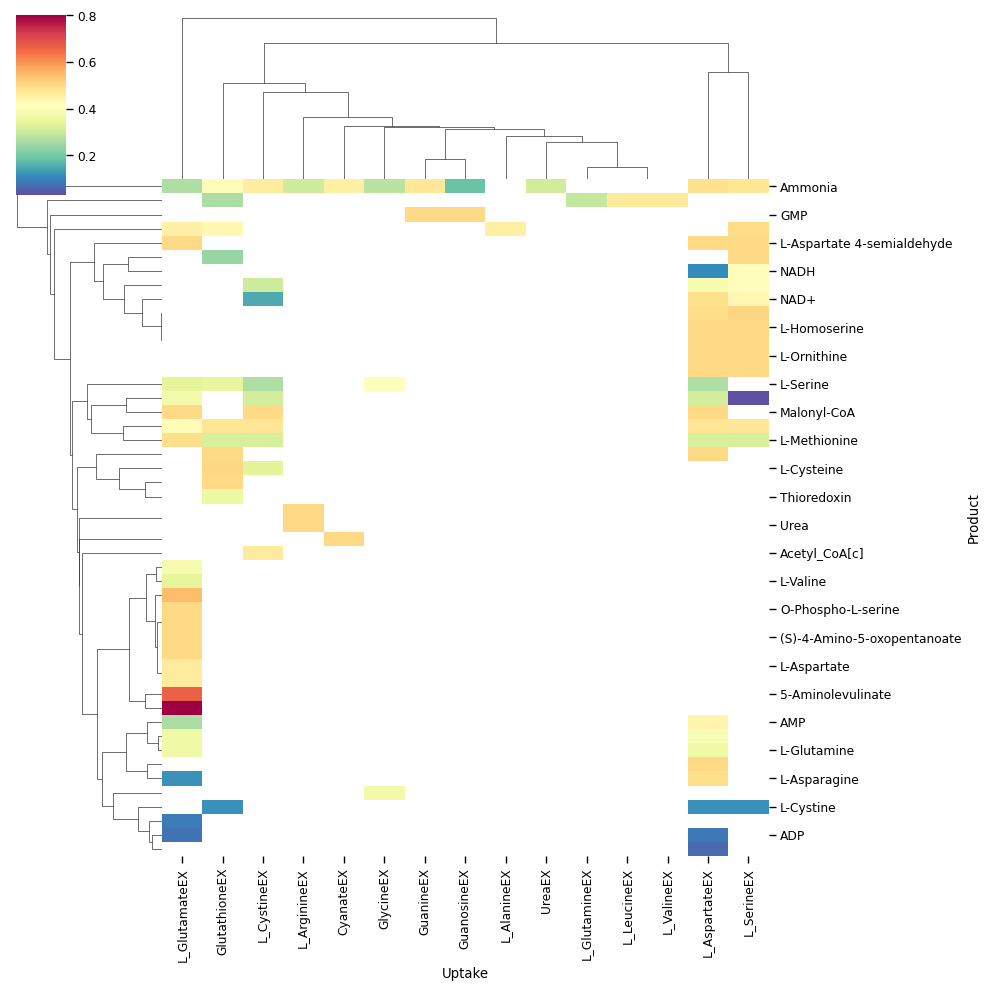

In [65]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', 
                                index=['Product',#'Name'
                                      ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    figsize=(10,10),
    #yticklabels= pdf.index.str.slice(0, 30),

              )

In [66]:
group_colors

{'Nitrogen metabolism': '#8dd3c7',
 'Arginine and proline metabolism': '#ffffb3',
 'Histidine metabolism': '#bebada',
 'Cysteine and methionine metabolism': '#fb8072',
 'Glycine, serine and threonine metabolism': '#80b1d3',
 'Phenylalanine, tyrosine and tryptophan biosynthesis': '#fdb462',
 'Alanine, aspartate and glutamate metabolism': '#b3de69',
 'Purine metabolism': '#fccde5',
 'Valine, leucine and isoleucine degradation': '#d9d9d9',
 'Pyruvate metabolism': '#bc80bd',
 'Other': '#cccccc'}

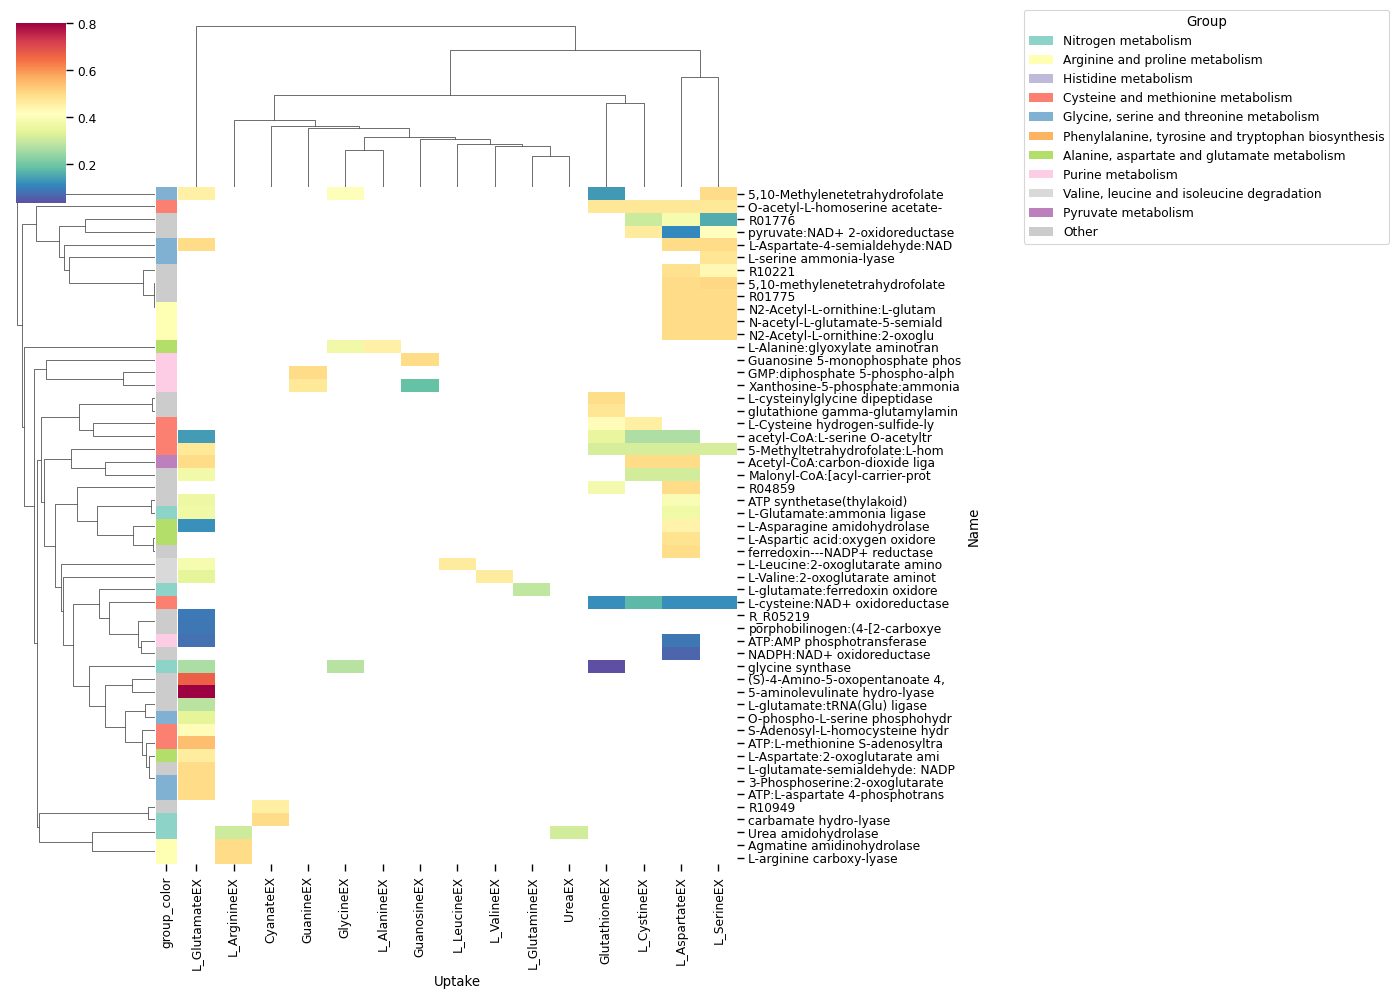

In [67]:
from matplotlib.patches import Patch

pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', index=[#'Product',
    'Name'], values='Percent_Production', aggfunc='mean', fill_value=0)
row_colors = df_paths.groupby('Name').group_color.first()

sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    yticklabels= pdf.index.str.slice(0, 30),
    row_colors=row_colors[pdf.index]

              )

handles = [Patch(facecolor=group_colors[name]) for name in group_colors]
plt.legend(handles, group_colors, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


In [68]:
pdf

Uptake,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Name,,,,,,,,,,,,,,,
"(S)-4-Amino-5-oxopentanoate 4,5-aminomutase",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000
3-Phosphoserine:2-oxoglutarate aminotransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
"5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase",0.000000,0.132459,0.406530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.452508,0.000000,0.000000,0.499784,0.000000,0.000000
"5,10-methylenetetrahydrofolate:NADP+ oxidoreductase",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.504829,0.000000,0.000000
5-Methyltetrahydrofolate:L-homocysteine S-methyltransferase,0.000000,0.319858,0.000000,0.000000,0.000000,0.000000,0.000000,0.319858,0.319858,0.472798,0.000000,0.000000,0.319858,0.000000,0.000000
5-aminolevulinate hydro-lyase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000
ATP synthetase(thylakoid),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393205,0.000000,0.365292,0.000000,0.000000,0.000000,0.000000,0.000000
ATP:AMP phosphotransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087592,0.000000,0.079613,0.000000,0.000000,0.000000,0.000000,0.000000
ATP:L-aspartate 4-phosphotransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


In [69]:
#df_paths['weight'] = df_paths['Flux']
df_paths['Line_width'] = (df_paths['Percent_Production'] +0.1) *10

G = nx.from_pandas_edgelist(df_paths, source='Reactant', target='Product', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')

In [70]:
# We could use figure here but don't want all the axes and titles
plot = Plot() # x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
# Create a Bokeh graph from the NetworkX input using nx.spring_layout
graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
plot.renderers.append(graph)

# Set some of the default node glyph (Circle) properties
graph.node_renderer.glyph.update(size=20, fill_color="orange")

# Set some edge properties too
graph.edge_renderer.glyph.update(line_width='Line_width')

graph.node_renderer.data_source.to_df()
#show(plot)

,index
0,Guanosine
1,GMP
2,Ammonia
3,L-Aspartate
4,L-Asparagine
...,...
84,L-Isoleucine
85,Agmatine
86,Cyanate
87,Carbamate


In [71]:
df_paths['Source'] = df_paths['Reactant']
df_paths['Target'] = df_paths['Product']


In [72]:
    met1 = 'CyanateEX'
    df = df_paths.loc[df_paths.Uptake.isin([met1])]
    df.loc[df.Index == 1, 'Source'].unique()


array(['Cyanate'], dtype=object)

In [73]:
df_paths.groupby(['Reaction', 'Group']).size().reset_index().Group.value_counts().head(10)

                                            15
Transport                                   13
Arginine and proline metabolism             13
Glycine, serine and threonine metabolism    12
Cysteine and methionine metabolism          10
Histidine metabolism                         9
Porphyrin and chlorophyll metabolism         6
Lysine biosynthesis                          5
Nitrogen metabolism                          5
Purine metabolism                            5
Name: Group, dtype: int64

In [74]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(10,)

In [75]:
df_paths.head()

,path_id,Index,Uptake,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,Group_Annotation,Reactant,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,Guanosine,Trans_Guanosine,Trans_Guanosine,10.557712,Guanosine[e] <=> Guanosine[c],0.499994,,,Guanosine,#cccccc,5.999943,Guanosine,Guanosine
1,1,2,GuanosineEX,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,SBO:0000633,Guanosine,#fccde5,5.999427,Guanosine,GMP
2,1,3,GuanosineEX,Ammonia,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.187664,Purine metabolism,SBO:0000633,GMP,#fccde5,2.876642,GMP,Ammonia
0,1,1,L_AspartateEX,L-Aspartate,AspartateTRANS,L_Aspartate Transport,9.509822,L_Aspartate[c] <=> L_Aspartate[e],0.497644,Transport,SBO:0000633,L-Aspartate,#cccccc,5.976440,L-Aspartate,L-Aspartate
1,1,2,L_AspartateEX,Ammonia,R00357,L-Aspartic acid:oxygen oxidoreductase,5.112795,H2O[c] + L_Aspartate[c] + Oxygen[c] --> Ammonia[c] + Hydrogen_peroxide[c] + Oxaloacetate[c],0.484834,"Alanine, aspartate and glutamate metabolism",SBO:0000633,L-Aspartate,#b3de69,5.848339,L-Aspartate,Ammonia


In [76]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [77]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot(df_paths, met1):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.loc[df_paths.Uptake.isin([met1])]
    met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    
    G = nx.from_pandas_edgelist(df.loc[df.Index != 1], 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin([met_name]),'Type'] = 'Uptake'

    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','Other'], (list(all_palettes['Category10'][3]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=300, height=300, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title=met_name)

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [78]:
from bokeh.plotting import figure
from bokeh import events
from bokeh.models import CustomJS, Div, Button
from bokeh.layouts import column, row

m = 'GlycineEX'
p = _create_plot(df_paths, m) 

# item_list = 
# legend = Legend(items=[
#     LegendItem(label="orange", renderers=[r], index=0),
#     LegendItem(label="red", renderers=[r], index=1),
# ])
# p.add_layout(legend)
# div = Div(width=400)
# layout = column(p, div)

# p.js_on_event(events.SelectionGeometry, CustomJS(args=dict(div=div), code="""
# div.text = "Selection! <p> <p>" + JSON.stringify(cb_obj.geometry, undefined, 2);
# """))

# show(layout)
show(p)

In [79]:
from bokeh.io import output_file, show
output_file("aa_production.html")
plots = [_create_plot(df_paths, m) for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_color" value "group_color", key "line_width" value "Line_width" [renderer: GlyphRenderer(id='1726', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "node_color" [renderer: GlyphRenderer(id='1722', ...)]


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_color" value "group_color", key "line_width" value "Line_width" [renderer: GlyphRenderer(id='1726', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "node_color" [renderer: GlyphRenderer(id='1722', ...)]


In [81]:
df_paths.to_excel('MED4_paths_to_ammonia.xlsx')

In [82]:
df_paths.head()

,path_id,Index,Uptake,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,Group_Annotation,Reactant,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,Guanosine,Trans_Guanosine,Trans_Guanosine,10.557712,Guanosine[e] <=> Guanosine[c],0.499994,,,Guanosine,#cccccc,5.999943,Guanosine,Guanosine
1,1,2,GuanosineEX,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,SBO:0000633,Guanosine,#fccde5,5.999427,Guanosine,GMP
2,1,3,GuanosineEX,Ammonia,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.187664,Purine metabolism,SBO:0000633,GMP,#fccde5,2.876642,GMP,Ammonia
0,1,1,L_AspartateEX,L-Aspartate,AspartateTRANS,L_Aspartate Transport,9.509822,L_Aspartate[c] <=> L_Aspartate[e],0.497644,Transport,SBO:0000633,L-Aspartate,#cccccc,5.976440,L-Aspartate,L-Aspartate
1,1,2,L_AspartateEX,Ammonia,R00357,L-Aspartic acid:oxygen oxidoreductase,5.112795,H2O[c] + L_Aspartate[c] + Oxygen[c] --> Ammonia[c] + Hydrogen_peroxide[c] + Oxaloacetate[c],0.484834,"Alanine, aspartate and glutamate metabolism",SBO:0000633,L-Aspartate,#b3de69,5.848339,L-Aspartate,Ammonia


In [85]:
colors = all_palettes['Category20'][16]

In [86]:
sns.color_palette(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451)]

In [92]:
lut = dict(zip(sorted(df_paths.Uptake.unique()), colors))

In [93]:
list(lut)

['AmmoniaEX',
 'CyanateEX',
 'GlutathioneEX',
 'GlycineEX',
 'GuanineEX',
 'GuanosineEX',
 'L_AlanineEX',
 'L_ArginineEX',
 'L_AspartateEX',
 'L_CystineEX',
 'L_GlutamateEX',
 'L_GlutamineEX',
 'L_LeucineEX',
 'L_SerineEX',
 'L_ValineEX',
 'UreaEX']

In [96]:
df_paths['uptake_color'] = df_paths.Uptake.map(lut)

In [98]:
df_paths[['Uptake','Reaction','uptake_color']].to_excel('amino_uptake_reactions_kegg.xlsx')

In [99]:
df_paths['Source1'] = df_paths['Source']
df_paths.loc[df_paths.Index == 2, 'Source1'] = df_paths.loc[df_paths.Index == 2, 'Source1']+ '_e'

In [103]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    #df = df_paths.loc[df_paths.Uptake.isin([met1])]
    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df = df_paths
    
    G = nx.from_pandas_edgelist(df.loc[df.Index != 1], 
                                source='Source1', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    aa_names_so = [i.name+ '_e' for i in amino_acid_metabolites]
    
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin(aa_names_so),'Type'] = 'Uptake'

    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','Other'], (list(all_palettes['Category10'][3]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=600, height=600, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               #title=met_name
               )

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [104]:
p = _create_plot_all(df_paths)
show(p)